# Toy Problem Demo

## Scope

Overview of Benchq:
- inputs and outputs
- components:
  - Transpilation (pyliqtr)
  - Jabalizer/ICM
  - Min code distance finding
  - Substrate scheduling


Wait a little for TA 1 and TA 1.5

### Goal: Introduction to Benchq Tool for Resource Estimation

## Agenda
- Quick overview of Benchq usage.
- What is a circuit graph? How do we produce them?
- How do circuit graphs help get resource estimates?
- Look at some pretty plots
  - Preparing a GHZ state
  - The fully connected graph

## Introduction to Graph Estimators

Let's go through a gory example of what benchq is doing for the case of a graph resource estimator.

First we need to import some things and install a python environment in your python installation. This might take a minute.

Running this line will install julia to your python installation. See README for details.

In [1]:
%matplotlib inline

from qiskit import QuantumCircuit
import networkx as nx


from benchq.compilation.circuits import pyliqtr_transpile_to_clifford_t
from benchq.compilation.graph_states import get_jabalizer_circuit_compiler, get_ruby_slippers_circuit_compiler
from benchq.resource_estimators.graph_estimator import (
    GraphResourceEstimator,
)

In [2]:
from benchq.quantum_hardware_modeling import BASIC_SC_ARCHITECTURE_MODEL

demo_circuit = QuantumCircuit.from_qasm_file("data/single_rotation.qasm")
architecture_model = BASIC_SC_ARCHITECTURE_MODEL

Next, transpile into Clifford + T.

In [3]:
clifford_t_circuit = pyliqtr_transpile_to_clifford_t(
    demo_circuit, circuit_precision=1e-2
)
print(clifford_t_circuit)

Circuit(operations=[H(0), Z(0), H(0), S†(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), H(0)], n_qubits=1)


Transform circuit into compiled data representing the time and space required to make the graph.

In [6]:
optimization = "Time"  # or "Space"
verbose = False
compiler = get_ruby_slippers_circuit_compiler()
compiler(clifford_t_circuit, optimization, verbose)

GSCInfo(num_logical_qubits=4, num_layers=22, graph_creation_tocks_per_layer=[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], t_states_per_layer=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], rotations_per_layer=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

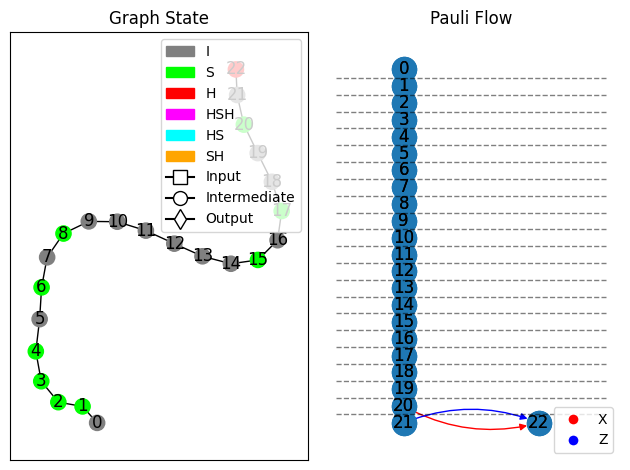

In [5]:
from benchq.compilation.graph_states import jl
from benchq.visualization_tools.plot_graph_state import plot_graph_state

asg, pauli_tracker, _ = jl.get_rbs_graph_state_data(clifford_t_circuit,takes_graph_input=False,gives_graph_output=False,verbose=verbose, optimization=optimization)
asg = jl.python_asg(asg)
pauli_tracker = jl.python_pauli_tracker(pauli_tracker)

plot_graph_state(asg, pauli_tracker)

On the left, you'll see the graph state that must be prepared in order for us to sample from a state that had the rotation performed on it.
There may be an isolated node here, this is just an artifact of the decomposition of the rotation.

On the right, you'll see the order in which each of the nodes must be measured in order to perform T gates. As expected they all must be measured one after the other, except our compiler was able to figure out that the last two can be measured simultaneously.

With use this graph to make resource estimates.

In [6]:
from benchq.resource_estimators.graph_estimator import GraphResourceEstimator
from benchq.algorithms.data_structures import (
    AlgorithmImplementation,
    ErrorBudget,
)
from benchq.compilation.graph_states import get_implementation_compiler

# 1% error margin split evenly between all sources of error
budget = ErrorBudget.from_even_split(1e-2)
# Specify the circuit and the margins of error we allow in the results
implementation = AlgorithmImplementation.from_circuit(
    clifford_t_circuit, budget, n_shots=1
)

# Specify how to run the circuit
estimator = GraphResourceEstimator(optimization, verbose)

# Modify our compiler to compile AlgorithmImplementation objects rather than just Circuits
implementation_compiler = get_implementation_compiler(compiler)


# run the estimator
resource_estimates = estimator.compile_and_estimate(
    implementation, implementation_compiler, architecture_model
)
print(resource_estimates)

get_program_compilation_wf-1 is SUCCEEDED


ResourceInfo(code_distance=11, logical_error_rate=0.01800563789423823, n_logical_qubits=30.0, n_physical_qubits=7260.0, total_time_in_seconds=0.000936, decoder_info=None, magic_state_factory_name='(15-to-1)_17,7,7', extra=<benchq.compilation.graph_states.compiled_data_structures.CompiledAlgorithmImplementation object at 0x189fec8d0>, hardware_resource_info=None)


### Summary

#### Minimal Inputs:
- Circuit
- Archetecture Model

#### Outputs:
- Number of physical qubits
- Computation time
- number of measurement steps (will be important later on!)

### Pipelines

#### Example usage

Typically, one would use a pipeline to combine all these steps into one command that benchq can follow.

Here we use one of the pre-configured pipelines called `get_precise_graph_estimate`.

In [7]:
from benchq.resource_estimators.default_estimators import (
    get_precise_graph_estimate,
)

# only allow a failure to occur 1% of the time
budget = ErrorBudget.from_even_split(1e-2)
implementation = AlgorithmImplementation.from_circuit(demo_circuit, budget, 1)
optimization = "Time"
resource_estimate = get_precise_graph_estimate(implementation, architecture_model, optimization)

print(resource_estimate)

ResourceInfo(code_distance=11, logical_error_rate=0.016815413530120026, n_logical_qubits=24.0, n_physical_qubits=5808.0, total_time_in_seconds=0.0010919999999999999, decoder_info=None, magic_state_factory_name='(15-to-1)_17,7,7', extra=<benchq.compilation.graph_states.compiled_data_structures.CompiledAlgorithmImplementation object at 0x189c83710>, hardware_resource_info=None)


get_program_compilation_wf-1 is SUCCEEDED


#### Default Pipelines
Benchq offers 5 default pipelines:

1. `get_precise_graph_estimate` - This pipeline uses the most accurate methods for estimating the resources required to run a circuit on a given architecture. It is also the slowest.
2. `get_fast_graph_estimate` - This pipeline uses faster methods for estimating the resources required to run a circuit on a given architecture. It is also less accurate.
3. `get_precise_extrapolation_estimate` - This pipeline uses the most accurate methods for estimating the resources required to get part of the graph. It will then extrapolate out to the size of the full graph.
4. `get_fast_extrapolation_estimate` - This pipeline uses the fastest methods for estimating the resources required to get part of the graph. It will then extrapolate out to the size of the full graph.
5. `get_footprint_estimate` - This pipeline is the fastest estimate, but is also the least accurate. It counts the number of T gates in the circuit and gets a space optimized estimate from that.

They can be imported with the following command:

```python
import benchq.resource_estimators.default_estimators import <pipeline name>
```

And run with the same inputs as above.

## What is a a Circuit Graph?

In [8]:
this_compiled_circuit_data = compiler(clifford_t_circuit, optimization="Time", verbose=True)

Compiling using Jabalizer...
Converting to Jabalizer Circuit...
Compiling to Algorithm Specific Graph...
Ordering non-clifford measurements...
Calculating number of logical qubits...
100% (23) completed in 0.0s
Running substrate scheduler...
Scheduling Clifford operations...
100% (24) completed in 0.0s
num_tocks_for_graph_creation: 24


### What does this do?

Recall that our circuit is in clifford + T form

- Replaces T gates with magic measurements and ancilla
- Use stabilizer simulator efficiently to push single qubit cliffords to one side
- Now we have a circuit of the form Initialization, CNOT, Measurement (ICM form)

In [9]:
print(clifford_t_circuit)

Circuit(operations=[H(0), Z(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), H(0)], n_qubits=1)


In [10]:
import data.get_icm as icm

circuit_after_icm = icm.get_icm(clifford_t_circuit)
print(circuit_after_icm)

Circuit(operations=[H(0), Z(0), CNOT(0,1), H(1), S(1), CNOT(1,2), H(2), S(2), CNOT(2,3), H(3), S(3), CNOT(3,4), H(4), S(4), CNOT(4,5), H(5), CNOT(5,6), H(6), S(6), CNOT(6,7), H(7), CNOT(7,8), H(8), S(8), CNOT(8,9), H(9), CNOT(9,10), H(10), CNOT(10,11), H(11), CNOT(11,12), H(12), CNOT(12,13), H(13), CNOT(13,14), H(14), CNOT(14,15), H(15), S(15), CNOT(15,16), H(16), CNOT(16,17), H(17), S(17), CNOT(17,18), H(18), CNOT(18,19), H(19), CNOT(19,20), H(20), S(20), CNOT(20,21), H(21), CNOT(21,22), H(22), H(22)], n_qubits=23)


The middle CNOTS are the interesting part:

- The CNOTS make a graph state
- Use stabilizer simulator to find graph state (Jabalizer)
- Return the resources required to make that graph state

(note there are a few long nodes because of a quirk in how we decomposed the rotation)

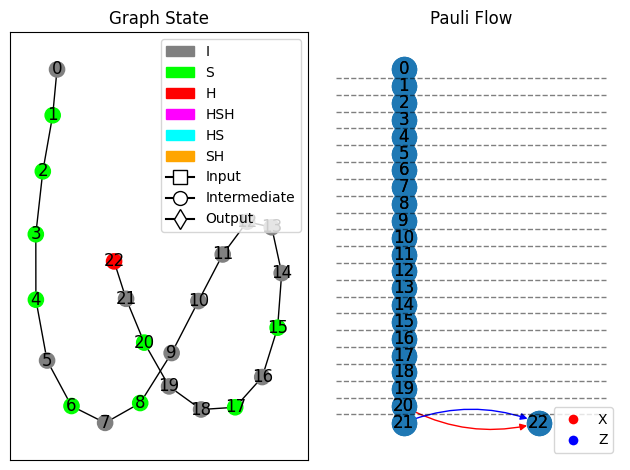

In [11]:
from benchq.compilation.graph_states import jl
from benchq.visualization_tools.plot_graph_state import plot_graph_state

asg, _, __ = jl.get_rbs_graph_state_data(clifford_t_circuit, takes_graph_input=False, gives_graph_output=False, verbose=False)
asg = jl.python_asg(asg)

plot_graph_state(asg, pauli_tracker)


Here we see a simple chain graph because our circuit structure simpy passes the qubits down the line generated by decomposing to clifford + T.

THere are two types of measurements which are required to perform the computation.
1. T basis measurements, the order of which is shown on the left.
2. Graph State preparation measurements, you can think of these as corresponding to creating all the edges for the graph on the left.

In the next section, we will explore how "schedules" the 2nd type or measurements.

### Summary

Circuit graphs are generated from the icm form of a circuit.

They are a representation of the graph state that is generated by the circuit.

## Getting Resource Estimates from Compiled Circuits

Rather than keep the whole graph, we extract the information we need to get resource estimates.

We store this in a `CompiledAlgorithmImplementation` object.

Let's make a `CompiledAlgorithmImplementation` object from our rotation circuit before it was decomposed.

In [12]:
compiled_implementation = implementation_compiler(implementation, optimization)
print(compiled_implementation.program.subroutines[0])

GSCInfo(num_logical_qubits=4, num_layers=3, graph_creation_tocks_per_layer=Julia:
3-element Vector{Int64}:
 3
 0
 0, t_states_per_layer=Julia:
3-element Vector{Int64}:
 0
 0
 0, rotations_per_layer=Julia:
3-element Vector{Int64}:
 1
 0
 0)


get_program_compilation_wf-1 is SUCCEEDED


As you can see, the compiled circuit data involves some data that comes from how the graph was made including `t_states_per_layer` and `rotations_per_layer`. These parameters tell us how many non-clifford resources the circuit consumes at one time.

`graph_creation_tocks_per_layer` is the number of measurement steps required to prepare that graph_state at each layer of the computation. It is used to calculate the time required to prepare the graph state.

Next, let's use `CompiledAlgorithmImplementation` to get some resource estimates.

In [13]:
resource_estimate = estimator.estimate_resources_from_compiled_implementation(
        compiled_implementation,
        architecture_model,
    ) 


print(f"distance: {resource_estimate.code_distance}")
print(f"physical qubit count: {resource_estimate.n_physical_qubits}")
print(f"total time: {resource_estimate.total_time_in_seconds}")

distance: 14
physical qubit count: 402976.0
total time: 0.0018468


And there you go! We have some resource estimates.

Don't worry  if the estimates are a little high, that's just because we didn't choose a smaller magic state factory for this calculation.

### How to make Circuit Graph State?

Since graph state is a stabilizer state, we measure stabilizers to generate it!

We could measure all the stabilizers to get the graph.

Measurements are expensive!! So how optimize?

### Substrate Scheduler

Tells us how to measure and which can be measured simultaneously.

In [14]:
from benchq.compilation.graph_states.substrate_scheduler.python_substrate_scheduler import python_substrate_scheduler

schedule = python_substrate_scheduler(asg, "fast")

formatted_measurement_steps = [
    [node[0] for node in step] for step in schedule.measurement_steps
]
print(formatted_measurement_steps)

[[2, 5, 8, 11, 14, 17, 20], [0, 3, 6, 9, 12, 15, 18, 21], [1, 4, 7, 10, 13, 16, 19, 22]]


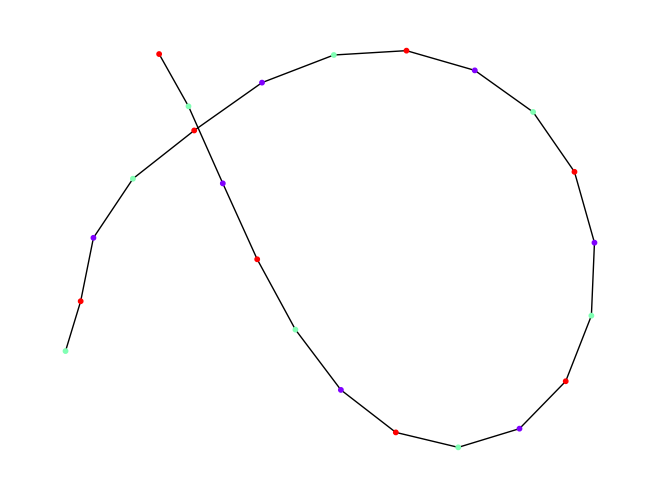

In [15]:
from benchq.visualization_tools.plot_substrate_scheduling import plot_graph_state_with_measurement_steps

plot_graph_state_with_measurement_steps(
    asg, schedule.measurement_steps
)

### Problem! Graph can get too big to handle!

#### Solution! Use subcircuits.

Quantum Algorithms are made up of repeated components.

Estimate resources for each component & multiply by the number of times it was used.

Will create a higher estimate.

More on this later!

## FINALLY! Pretty Graph Time!

Let's look at the graphs of circuits to examine measurement steps!

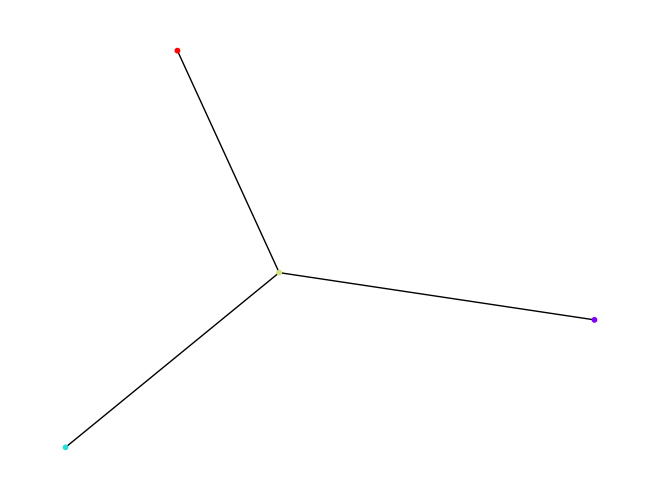

In [16]:
from benchq.conversions import import_circuit

ghz_circuit = import_circuit(QuantumCircuit.from_qasm_file("data/ghz_circuit.qasm"))

asg, _, __ = jl.get_rbs_graph_state_data(ghz_circuit, takes_graph_input=False, gives_graph_output=False, verbose=False)
asg = jl.python_asg(asg)

schedule = python_substrate_scheduler(asg, "fast")

plot_graph_state_with_measurement_steps(
    asg, schedule.measurement_steps
)

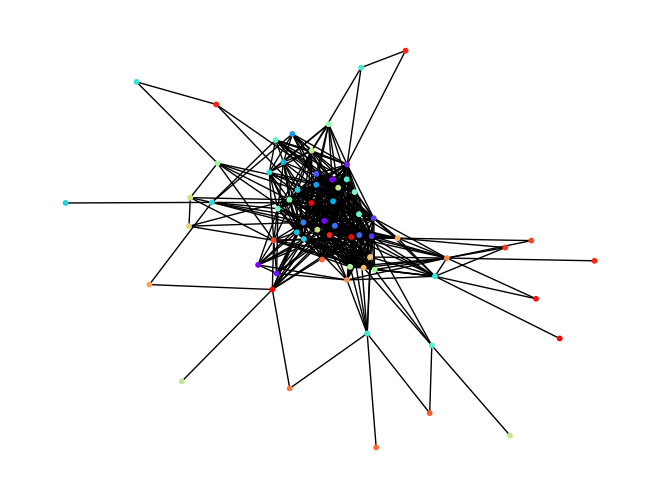

In [17]:
h_chain_circuit = import_circuit(QuantumCircuit.from_qasm_file("data/h_chain_circuit.qasm"))

asg, _, __ = jl.get_rbs_graph_state_data(h_chain_circuit, takes_graph_input=False, gives_graph_output=False, verbose=False)
asg = jl.python_asg(asg)

schedule = python_substrate_scheduler(asg, "fast")

plot_graph_state_with_measurement_steps(
    asg, schedule.measurement_steps
)

## Closing Statements

### What did we learn?


#### Inputs
- Circuit
- Architecture model
#### Outputs
- Number of physical qubits
- Computation time
- Number of measurement steps



#### Components:
- Transpilation (pyliqtr)
  - Bring to Clifford + T
- Jabalizer/ICM
  - Easy way to represent circuit
- Min code distance finding
  - Number of physical qubits
  - Computation time
- Substrate scheduling
  - number of measurement steps

## What's Next?

- How to get resource estimate for large algorithms? (QuantumPrograms)
- Compare to other resource estimators.
- Try this notebook out for yourself!!